In [47]:
from __future__ import print_function, division

import numpy as np
import os
import pickle

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms

import sklearn.model_selection as model_selection

In [48]:
# Import data set
dataset = []
with open('nparr_spec_image.pickle','rb') as modelFile:
     dataset = pickle.load(modelFile)

In [49]:
print(dataset[0][0].shape)

(303, 722)


In [50]:
print(np.matrix(dataset[0][0]))

[[166 176 176 ... 241 241 241]
 [165 175 175 ... 255 255 255]
 [165 175 175 ... 255 255 255]
 ...
 [238 252 252 ... 255 255 255]
 [237 251 251 ... 255 255 255]
 [237 251 251 ... 255 255 255]]


# Import Model

In [51]:
# Initialize ResNet model with initial weights
tf_model = models.resnet18(weights = models.ResNet18_Weights.DEFAULT)

In [52]:
print(tf_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Modify initial and last layers to allow model to adapt to our inputs/outputs.

In [53]:
# Get last layer and reset last linear layer
last_name, last_layer = list(tf_model.named_modules())[-1]
tf_model.fc = nn.Linear(in_features=512, out_features=10, bias=True)

# Prepend initial layers
tf_model.conv1 = nn.Sequential(
    nn.Conv2d(1, 3, kernel_size= (9,9), stride=(4,4), padding=(3,3)),
    nn.BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
    nn.ReLU(inplace=True),
    tf_model.conv1
)
print(tf_model.named_modules)

<bound method Module.named_modules of ResNet(
  (conv1): Sequential(
    (0): Conv2d(1, 3, kernel_size=(9, 9), stride=(4, 4), padding=(3, 3))
    (1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  )
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tr

# Create Dataloaders

In [54]:
classes = ['bird', 'cat', 'chicken', 'cow', 'dog', 'donkey', 'frog', 'lion', 'monkey', 'sheep']
import operator
batch_size = 4

# Used from Google Gemini
from torch.utils.data import Dataset
class DAN_Dataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = torch.tensor(data)
        self.labels = torch.tensor(labels)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]


def fetch_dataloader(data, batch_size, train_transform=None, val_transform=None):
    '''
    Inputs:
    :param data: Data to load into DataLoaders.
    :param batch_size: Batch size for DataLoaders.
    :param train_transform: Transforms to apply to train Dataset
    :param val_transform: Transforms to apply to validation Dataset
    '''
    # https://www.geeksforgeeks.org/python-get-first-element-in-list-of-tuples/
    images = list(map(operator.itemgetter(0), dataset))
    images = np.array(images).astype(np.float32)
    # Grab lowercase labels and convert to integers
    labels = list(map(operator.itemgetter(1), dataset))
    labels = list(map(lambda x: x.lower(), labels))
    labels = list(map(lambda x: classes.index(x), labels))

    # Split into train and validation sets.
    x_train, x_val, y_train, y_val  = model_selection.train_test_split(images, labels, train_size=0.8, shuffle=True)
    # Convert to Dataset
    train_data = DAN_Dataset(x_train, y_train, train_transform)
    val_data = DAN_Dataset(x_val, y_val, val_transform)

    # Separate every 10th value
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True, num_workers=2)
    return train_loader, val_loader


train_transform = transforms.Compose(
    [transforms.ToTensor(), 
     transforms.ConvertImageDtype(torch.float32),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

val_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.ConvertImageDtype(torch.float32),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [55]:
train, val = fetch_dataloader(dataset, batch_size, train_transform, val_transform)

# Training

In [56]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

tf_model.to(device)
tf_model.train()

# Set the loss function and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(tf_model.parameters(), lr=0.001, momentum=0.9)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [65]:
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = torch.reshape(inputs, (4, 1, 303, 722))
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = tf_model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 1000 == 999:    # print every 1000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 1000))
            running_loss = 0.0

print('Finished Training')

Finished Training


# Evaluate Model

In [58]:
# Gemini generated code with google search: "pytorch evaluate accuracy of model"
from torchmetrics import Accuracy

def evaluate_model(model, data_val, classes, device):
    model.eval()
    predictions = []
    accuracy = Accuracy(task='multiclass', num_classes=classes).to(device)
    with torch.no_grad():
        for i, data in enumerate(data_val, 0):
            # get the inputs; data is a list of [inputs, labels]
            try:
                inputs, labels = data
                inputs = torch.reshape(inputs, (inputs.shape[0], 1, 303, 722))
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                predictions.append(outputs)
                accuracy.update(outputs, labels)
            except:
                continue
        return accuracy.compute(), predictions

In [ ]:

import torch
from torchmetrics import Accuracy, AUROC, ConfusionMatrix
from sklearn.preprocessing import label_binarize
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def evaluate_model_comprehensive(model, data_val, classes, device, class_names=None):
    
    model.eval()
    all_preds_prob = []
    all_labels = []
    
    # Initialize metric
    # https://lightning.ai/docs/torchmetrics/stable/classification/accuracy.html
    # https://lightning.ai/docs/torchmetrics/stable/classification/auroc.html
    # https://lightning.ai/docs/torchmetrics/stable/classification/confusion_matrix.html
    
    accuracy = Accuracy(task='multiclass', num_classes=classes).to(device)
    auroc = AUROC(task='multiclass', num_classes=classes).to(device)
    conf_matrix = ConfusionMatrix(task='multiclass', num_classes=classes).to(device)
    
    with torch.no_grad():
        for data in data_val:
            try:
                inputs, labels = data
                inputs = torch.reshape(inputs, (inputs.shape[0], 1, 303, 722))
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                outputs = model(inputs)
                probs = torch.softmax(outputs, dim=1)
                
                # Update metrics
                accuracy.update(outputs, labels)
                auroc.update(probs, labels)
                conf_matrix.update(outputs, labels)
                
                # Store probabilities and labels for ROC curves
                all_preds_prob.extend(probs.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                
            except Exception as e:
                print(f"Error processing batch: {e}")
                continue
    
    # Convert lists to numpy arrays
    all_preds_prob = np.array(all_preds_prob)
    all_labels = np.array(all_labels)
    
    # Compute final metrics
    acc = accuracy.compute()
    auc_score = auroc.compute()
    cm = conf_matrix.compute()
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm.cpu().numpy(), 
                annot=True, 
                fmt='g',
                cmap='Blues',
                xticklabels=class_names if class_names else range(classes),
                yticklabels=class_names if class_names else range(classes))
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    
    # Plot ROC curves
    plt.figure(figsize=(10, 8))
    colors = plt.cm.rainbow(np.linspace(0, 1, classes))
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    # Binarize labels for ROC curve calculation
    labels_bin = label_binarize(all_labels, classes=range(classes))
    
    for i in range(classes):
        fpr[i], tpr[i], _ = roc_curve(labels_bin[:, i], all_preds_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        
        # Plot ROC curves
        plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
                label=f'{class_names[i] if class_names else f"Class {i}"} '
                      f'(AUC = {roc_auc[i]:0.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curves')
    plt.legend(loc="lower right", bbox_to_anchor=(1.7, 0.5))
    plt.tight_layout()
    
    # Calculate per-class metrics
    cm_numpy = cm.cpu().numpy()
    per_class_accuracy = cm_numpy.diagonal() / cm_numpy.sum(axis=1)
    
    # Print results
    print(f"Overall Accuracy: {acc:.4f}")
    print(f"ROC AUC (macro): {auc_score:.4f}")
    print("\nPer-class Accuracy:")
    for i, acc in enumerate(per_class_accuracy):
        class_name = class_names[i] if class_names else f"Class {i}"
        print(f"{class_name}: {acc:.4f}")
    
    return {
        'accuracy': acc,
        'roc_auc': auc_score,
        'confusion_matrix': cm,
        'predictions': np.argmax(all_preds_prob, axis=1),
        'true_labels': all_labels,
        'per_class_accuracy': per_class_accuracy,
        'per_class_roc_auc': roc_auc,
        'fpr': fpr,
        'tpr': tpr
    }

In [ ]:
def plot_misclassifications(model, data_val, device, class_names=None):
    model.eval()
    incorrect_samples = []
    incorrect_preds = []
    correct_labels = []
    pred_probs = []
    
    with torch.no_grad():
        for inputs, labels in data_val:
            # Ensure inputs are properly shaped and on the right device
            if len(inputs.shape) == 2:
                inputs = inputs.unsqueeze(0).unsqueeze(0)  # Add batch and channel dims
            elif len(inputs.shape) == 3:
                inputs = inputs.unsqueeze(1)  # Add channel dim if missing
                
            inputs = inputs.float().to(device)  # Ensure float type
            labels = labels.to(device)
            
            # Get model predictions
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs.data, 1)
            
            # Find incorrect predictions
            incorrect_mask = (predicted != labels)
            
            if incorrect_mask.any():
                wrong_indices = incorrect_mask.nonzero().squeeze(1)
                for idx in wrong_indices:
                    # Store original spectrogram (before reshaping)
                    incorrect_samples.append(inputs[idx, 0].cpu().numpy())
                    incorrect_preds.append(predicted[idx].item())
                    correct_labels.append(labels[idx].item())
                    pred_probs.append(probs[idx].cpu().numpy())
    
    # Plot incorrect classifications
    n_samples = len(incorrect_samples)
    if n_samples == 0:
        print("No misclassifications found!")
        return
        
    n_cols = min(4, n_samples)
    n_rows = (n_samples + n_cols - 1) // n_cols
    
    plt.figure(figsize=(20, 5*n_rows))
    
    for idx in range(n_samples):
        plt.subplot(n_rows, n_cols, idx + 1)
        
        # Plot spectrogram
        plt.imshow(incorrect_samples[idx], aspect='auto', cmap='viridis')
        
        # Get prediction confidence
        confidence = pred_probs[idx][incorrect_preds[idx]] * 100
        
        # Get class names 
        pred_label = class_names[incorrect_preds[idx]] if class_names else f"Class {incorrect_preds[idx]}"
        true_label = class_names[correct_labels[idx]] if class_names else f"Class {correct_labels[idx]}"
        
        # Create title with colored labels and confidence
        title = f'Pred: {pred_label} ({confidence:.1f}%)\nTrue: {true_label}'
        plt.title(title, color='black', 
                 bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', pad=3),
                 pad=10)
                 
        plt.axis('off')
    
    plt.tight_layout(pad=3.0)
    plt.show()
    
    # Print summary
    print(f"\nTotal misclassifications: {n_samples}")
    if n_samples > 0:
        # Calculate most common misclassifications
        from collections import Counter
        pairs = [(f"{class_names[true] if class_names else true} → {class_names[pred] if class_names else pred}" 
                 for true, pred in zip(correct_labels, incorrect_preds))]
        common_errors = Counter(pairs).most_common(3)
        
        print("\nMost common misclassifications:")
        for error_pair, count in common_errors:
            print(f"{error_pair}: {count} times")

In [104]:
dataset[0][0], dataset[0][1]

(array([[166, 176, 176, ..., 241, 241, 241],
        [165, 175, 175, ..., 255, 255, 255],
        [165, 175, 175, ..., 255, 255, 255],
        ...,
        [238, 252, 252, ..., 255, 255, 255],
        [237, 251, 251, ..., 255, 255, 255],
        [237, 251, 251, ..., 255, 255, 255]], dtype=uint8),
 'Bird')

Overall Accuracy: 0.9029
ROC AUC (macro): 0.9886

Per-class Accuracy:
bird: 1.0000
cat: 0.9545
chicken: 0.7143
cow: 1.0000
dog: 0.9130
donkey: 0.5000
frog: 0.5000
lion: 1.0000
monkey: 0.7500
sheep: 0.5000


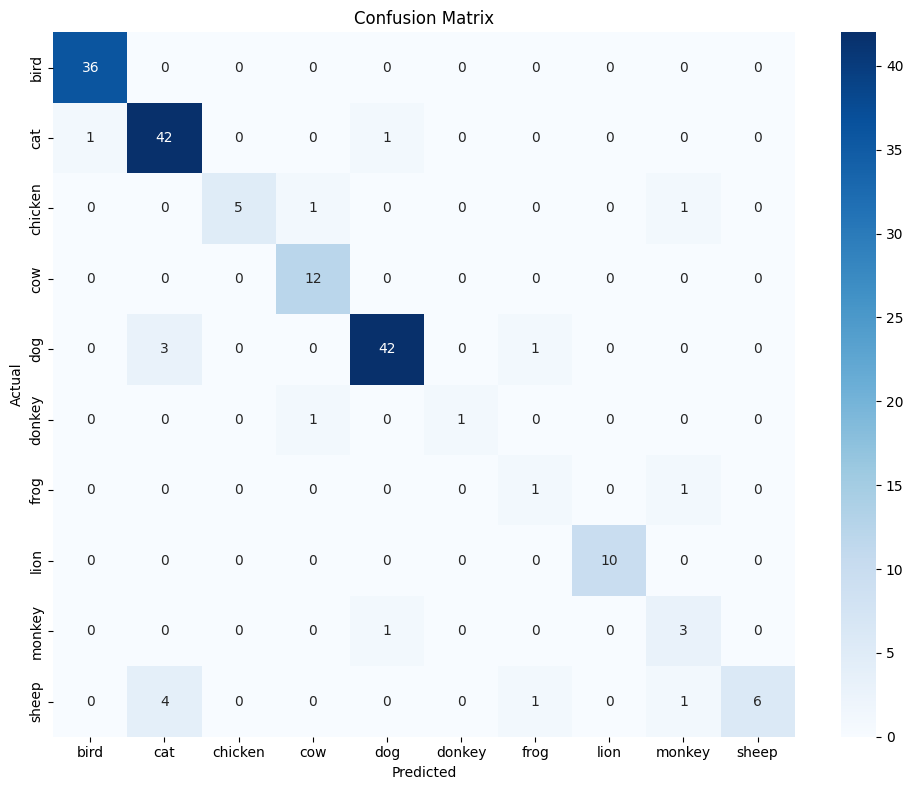

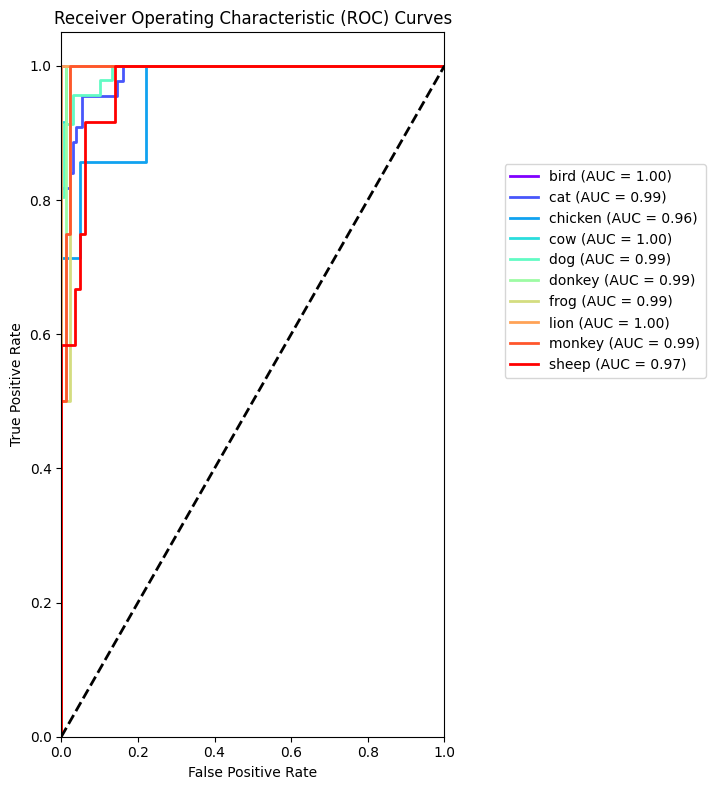

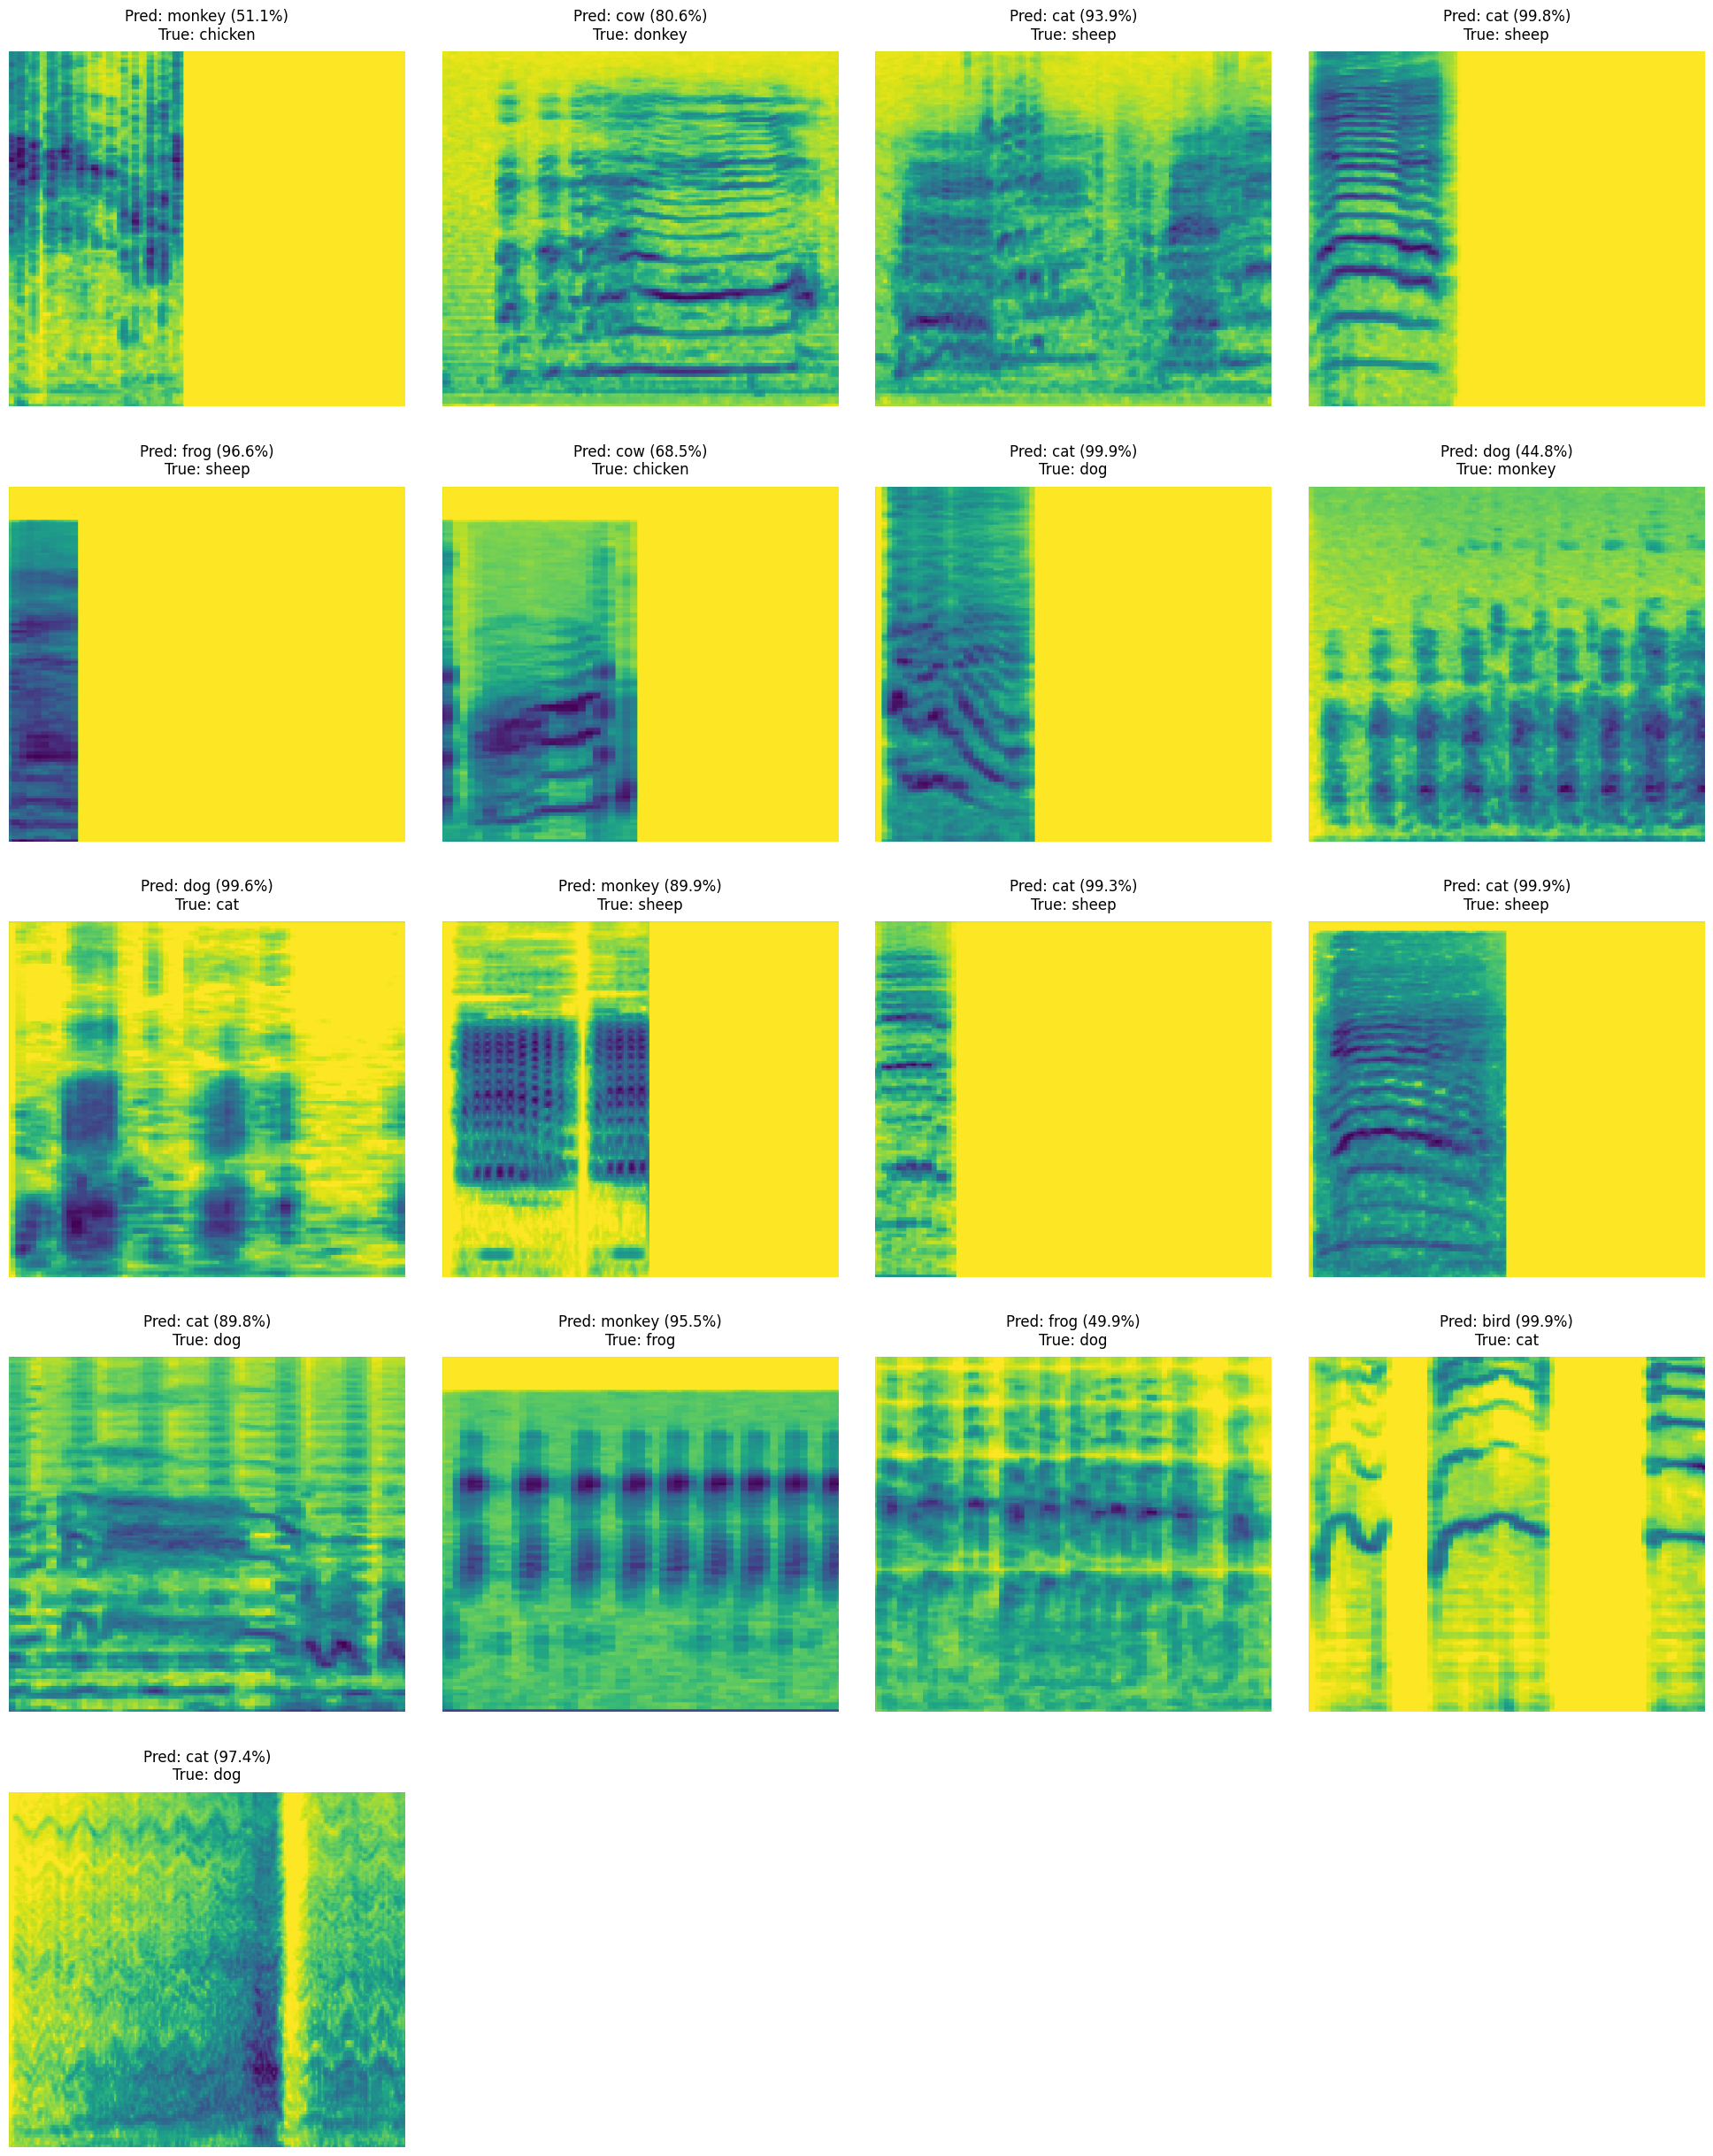


Total misclassifications: 17

Most common misclassifications:
<generator object plot_misclassifications.<locals>.<genexpr> at 0x7f7bec58c350>: 1 times
ROC AUC: 0.9886067509651184

Predictions: [3 3 7 8 4 1 4 0 4 2 4 1 0 3 4 0 3 1 6 4 3 0 0 4 4 4 1 0 3 0 1 1 4 7 0 7 4
 9 4 4 5 4 4 9 4 1 1 0 7 1 4 1 1 4 1 8 1 3 0 4 1 8 4 1 7 1 9 3 1 1 4 7 1 0
 4 1 4 1 4 1 3 6 0 1 8 1 9 0 1 2 0 1 1 0 9 7 0 1 0 4 0 3 1 1 0 4 1 4 0 1 0
 0 4 0 2 1 1 1 0 7 4 0 1 4 8 0 7 4 3 2 1 3 1 1 4 0 3 4 4 4 2 9 0 1 4 0 1 4
 4 4 0 4 3 1 0 8 0 1 4 6 1 0 1 7 0 1 1 0 1 4 0 1 4 4 0]

Class names: ['bird', 'cat', 'chicken', 'cow', 'dog', 'donkey', 'frog', 'lion', 'monkey', 'sheep']


In [120]:
classes = ['bird', 'cat', 'chicken', 'cow', 'dog', 'donkey', 'frog', 'lion', 'monkey', 'sheep']

# Run evaluation
results = evaluate_model_comprehensive(tf_model, val, len(classes), device, class_names=classes)
plot_misclassifications(tf_model, val, device, classes)

# Print metrics
print(f"ROC AUC: {results['roc_auc']}")

pred_labels = results['predictions']
print("\nPredictions:", pred_labels)
print("\nClass names:", classes)

In [118]:
def plot_correct_predictions(model, data_val, target_class, device, class_names=None, num_samples=10):
    
    model.eval()
    correct_samples = []
    confidence_scores = []
    
    # Convert target_class to index if it's a string
    if isinstance(target_class, str) and class_names is not None:
        target_class = class_names.index(target_class)
    
    class_name = class_names[target_class] if class_names else f"Class {target_class}"
    
    with torch.no_grad():
        for inputs, labels in data_val:
            # Only process samples of the target class
            target_mask = (labels == target_class)
            if not target_mask.any():
                continue
                
            # Get samples of target class
            target_inputs = inputs[target_mask]
            target_labels = labels[target_mask]
            
            # Ensure proper input shape
            if len(target_inputs.shape) == 2:
                target_inputs = target_inputs.unsqueeze(0).unsqueeze(0)
            elif len(target_inputs.shape) == 3:
                target_inputs = target_inputs.unsqueeze(1)
                
            target_inputs = target_inputs.float().to(device)
            target_labels = target_labels.to(device)
            
            # Get model predictions
            outputs = model(target_inputs)
            probs = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs.data, 1)
            
            # Find correct predictions
            correct_mask = (predicted == target_labels)
            if correct_mask.any():
                correct_idx = correct_mask.nonzero().squeeze(1)
                for idx in correct_idx:
                    correct_samples.append(target_inputs[idx, 0].cpu().numpy())
                    confidence_scores.append(probs[idx, target_class].item() * 100)
                    
                    # Break if we have enough samples
                    if len(correct_samples) >= num_samples:
                        break
        
        if not correct_samples:
            print(f"No correct predictions found for {class_name}!")
            return
            
        # Take only the requested number of samples
        correct_samples = correct_samples[:num_samples]
        confidence_scores = confidence_scores[:num_samples]
        
        # Plot settings
        n_cols = min(4, len(correct_samples))
        n_rows = (len(correct_samples) + n_cols - 1) // n_cols
        
        plt.figure(figsize=(20, 5*n_rows))
        plt.suptitle(f'Correct Predictions for {class_name}', fontsize=16, y=1.02)
        
        for idx, (sample, conf) in enumerate(zip(correct_samples, confidence_scores)):
            plt.subplot(n_rows, n_cols, idx + 1)
            plt.imshow(sample, aspect='auto', cmap='viridis')
            plt.title(f'Confidence: {conf:.1f}%', 
                     bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', pad=3))
            plt.axis('off')
        
        plt.tight_layout()
        plt.show()
        
        # Print summary statistics
        print(f"\nSummary for {class_name}:")
        print(f"Average confidence: {np.mean(confidence_scores):.1f}%")
        print(f"Min confidence: {min(confidence_scores):.1f}%")
        print(f"Max confidence: {max(confidence_scores):.1f}%")
        
        return {
            'samples': correct_samples,
            'confidences': confidence_scores,
            'avg_confidence': np.mean(confidence_scores)
        }

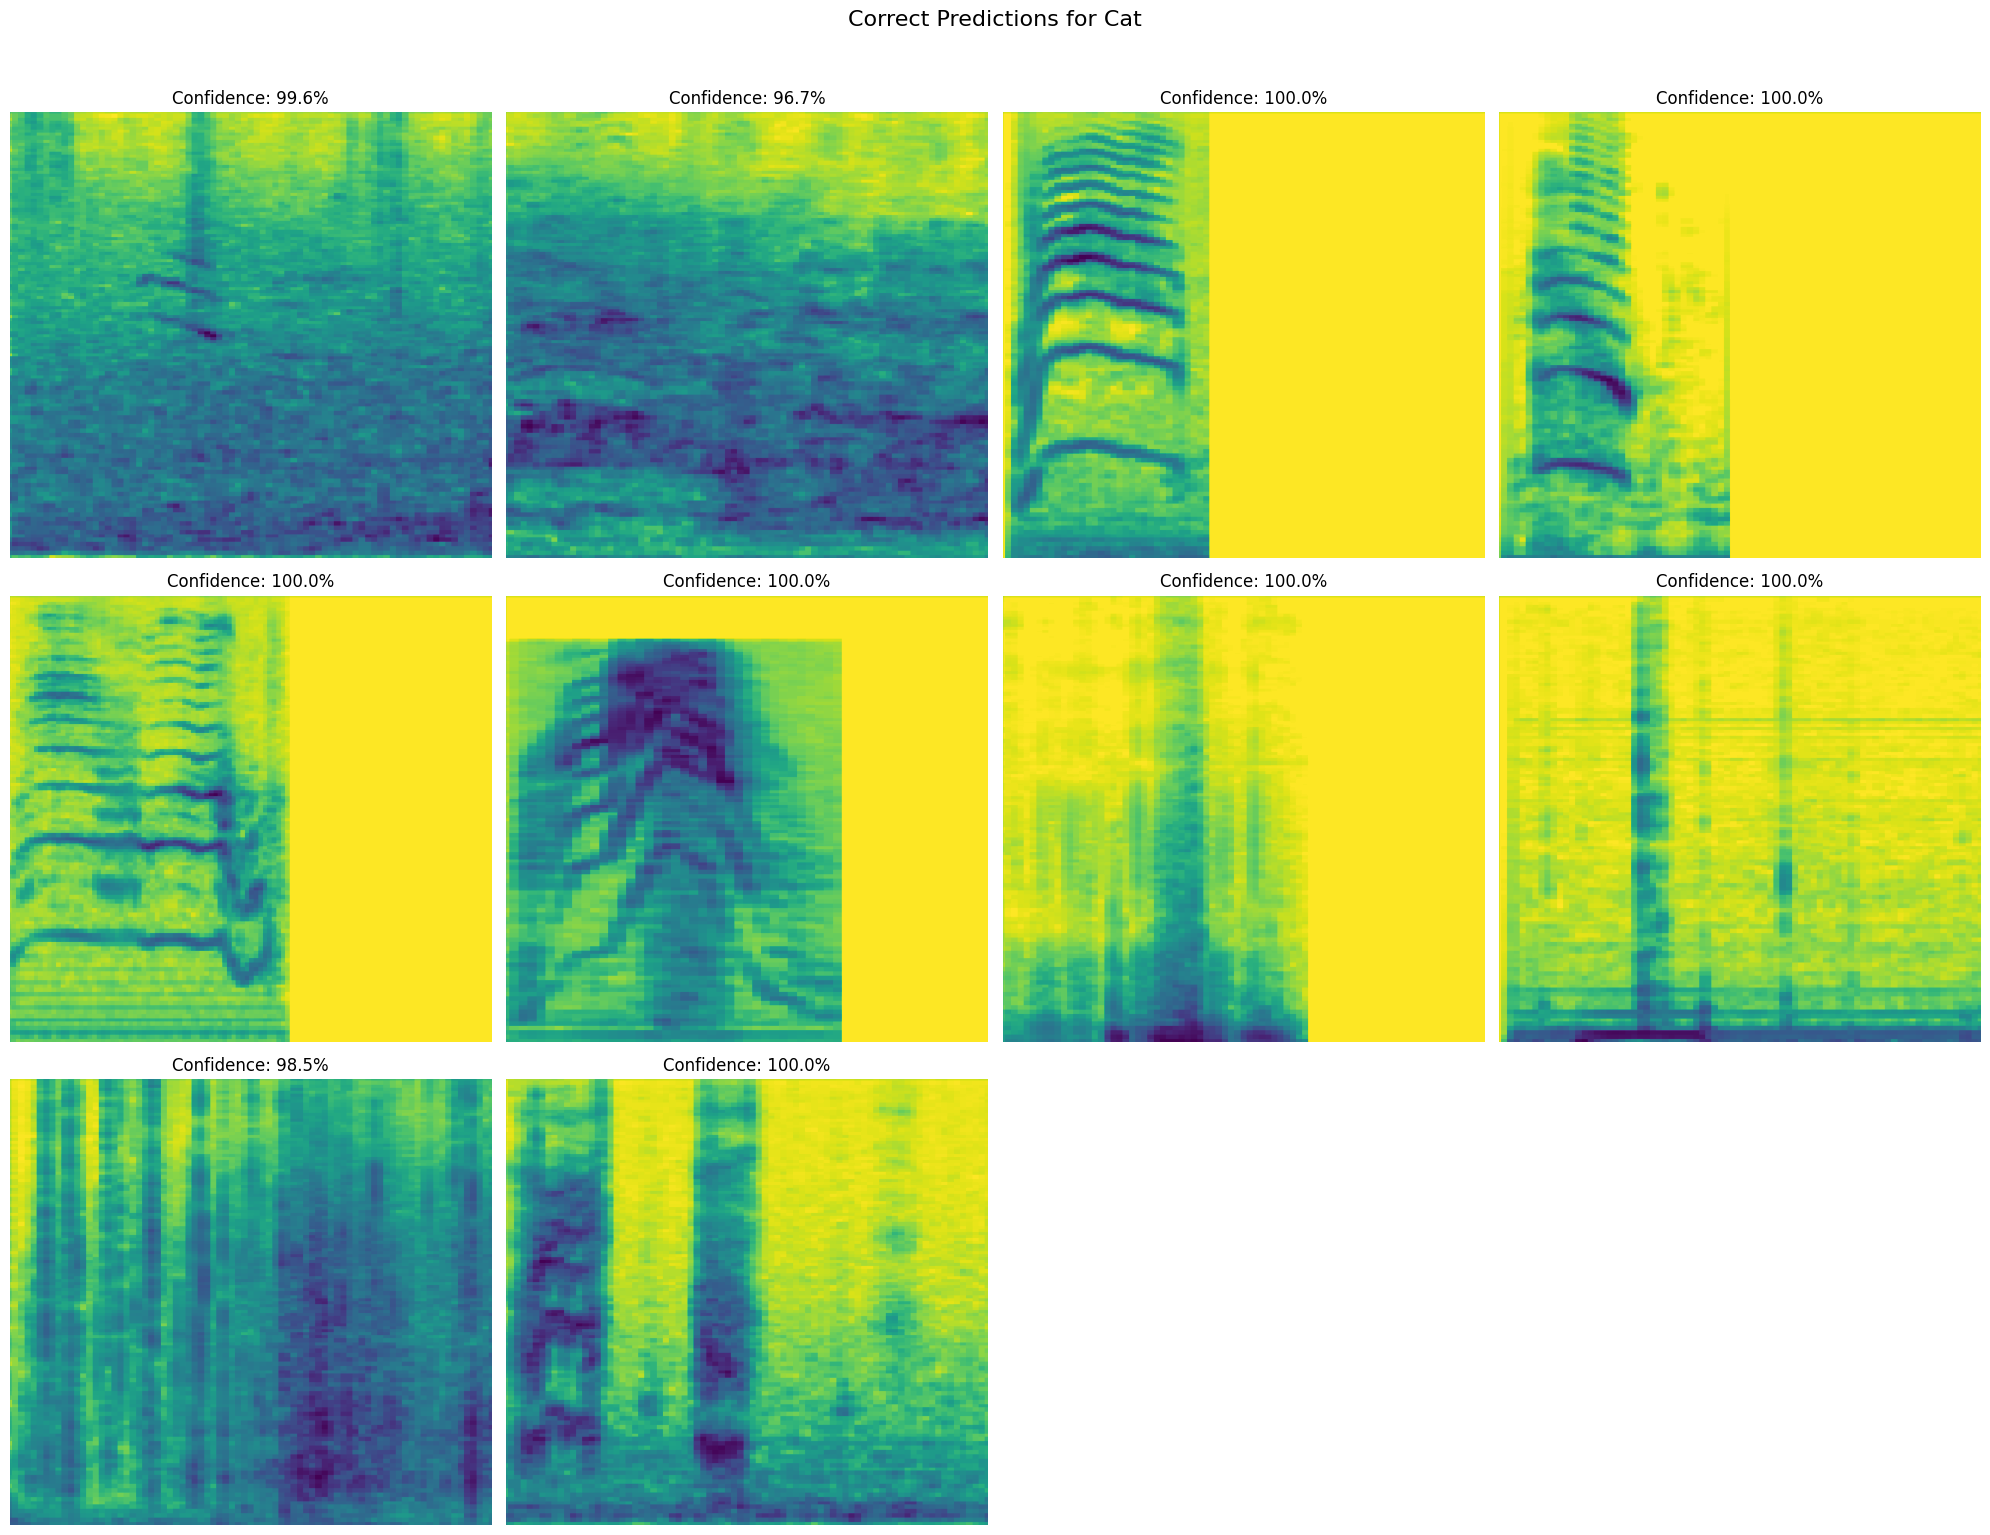


Summary for Cat:
Average confidence: 99.5%
Min confidence: 96.7%
Max confidence: 100.0%


{'samples': [array([[155., 165., 165., ..., 168., 168., 168.],
         [170., 180., 180., ..., 169., 169., 169.],
         [170., 180., 180., ..., 169., 169., 169.],
         ...,
         [101., 107., 107., ...,  87.,  87.,  87.],
         [145., 154., 154., ..., 126., 126., 126.],
         [145., 154., 154., ..., 126., 126., 126.]], dtype=float32),
  array([[206., 219., 219., ..., 216., 216., 216.],
         [215., 228., 228., ..., 222., 222., 222.],
         [215., 228., 228., ..., 222., 222., 222.],
         ...,
         [150., 159., 159., ..., 152., 152., 152.],
         [122., 130., 130., ..., 132., 132., 132.],
         [122., 130., 130., ..., 132., 132., 132.]], dtype=float32),
  array([[227., 241., 241., ..., 241., 241., 241.],
         [241., 255., 255., ..., 255., 255., 255.],
         [241., 255., 255., ..., 255., 255., 255.],
         ...,
         [241., 255., 255., ..., 255., 255., 255.],
         [241., 255., 255., ..., 255., 255., 255.],
         [241., 255., 255., .

In [119]:
plot_correct_predictions(tf_model, val, target_class="Cat", device=device, class_names=class_names)

Generating spectrogram visualizations...

Generating dataset statistics...


/tmp/ipykernel_4502/3389642734.py:114: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0,0].set_xticklabels(class_names, rotation=45)
/tmp/ipykernel_4502/3389642734.py:120: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0,1].set_xticklabels(class_names, rotation=45)
/tmp/ipykernel_4502/3389642734.py:126: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1,0].set_xticklabels(class_names, rotation=45)
/tmp/ipykernel_4502/3389642734.py:133: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1,1].set_xticklabels(class_names, rotation=45)


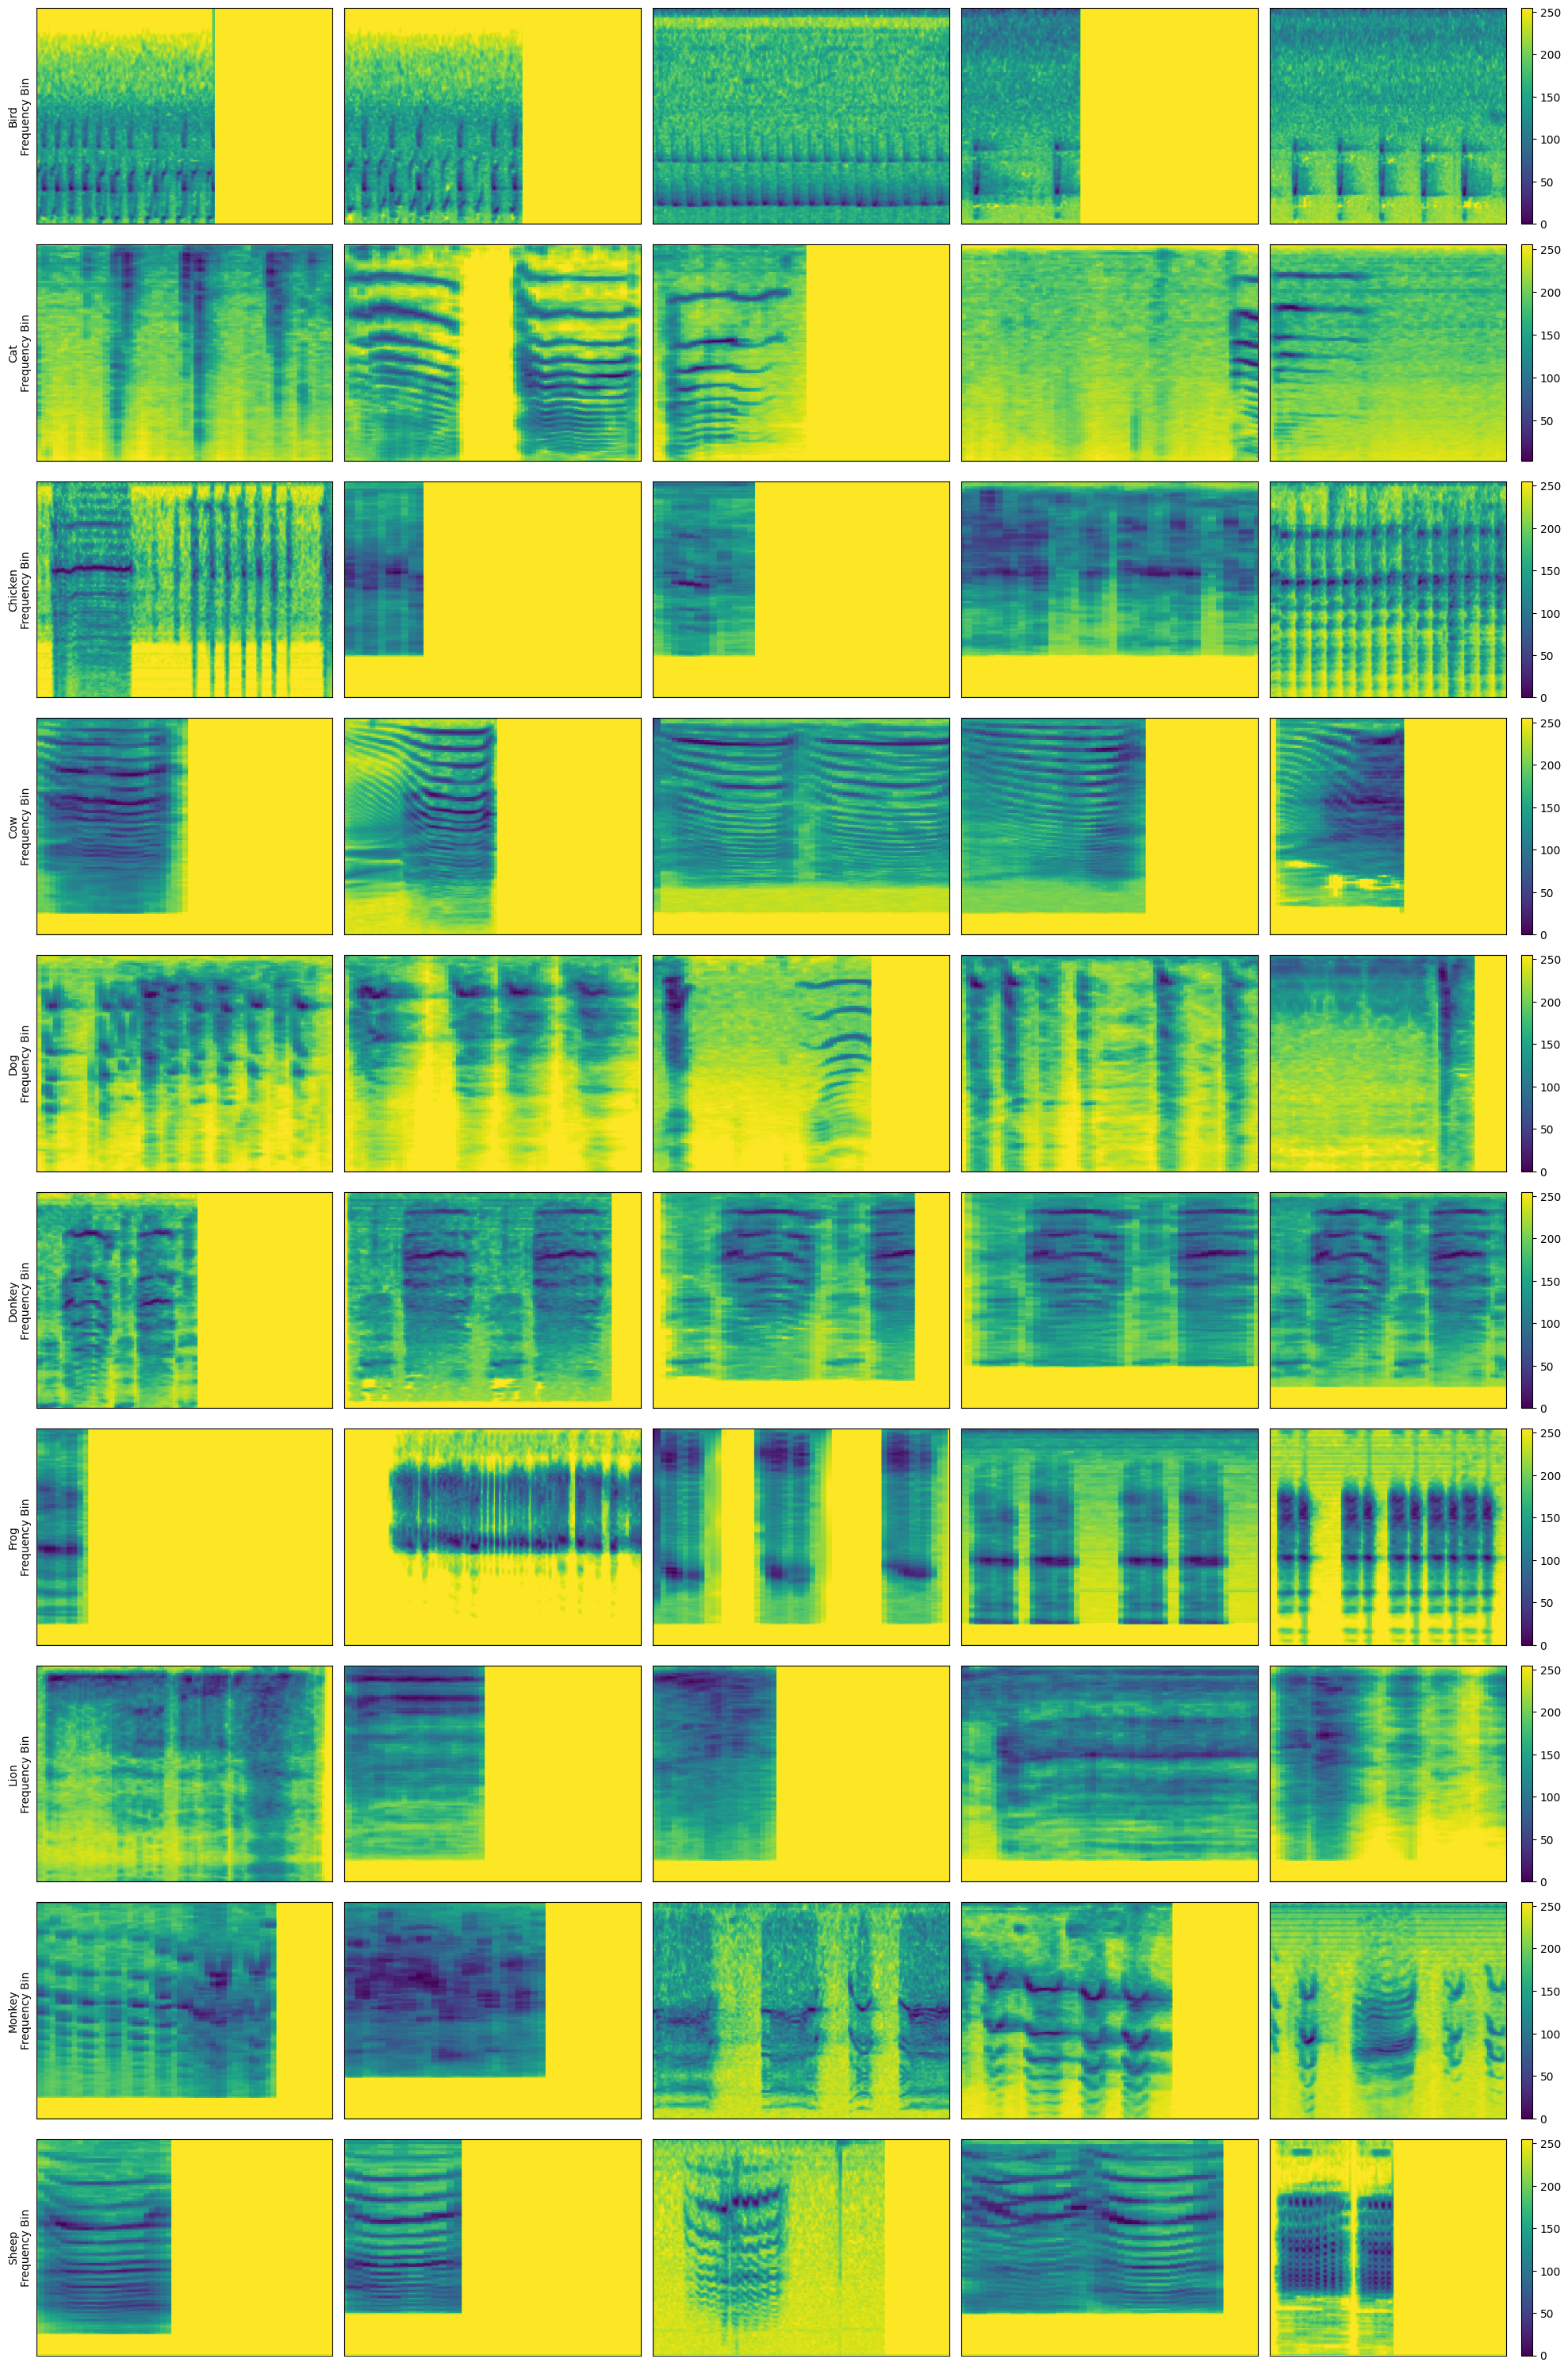

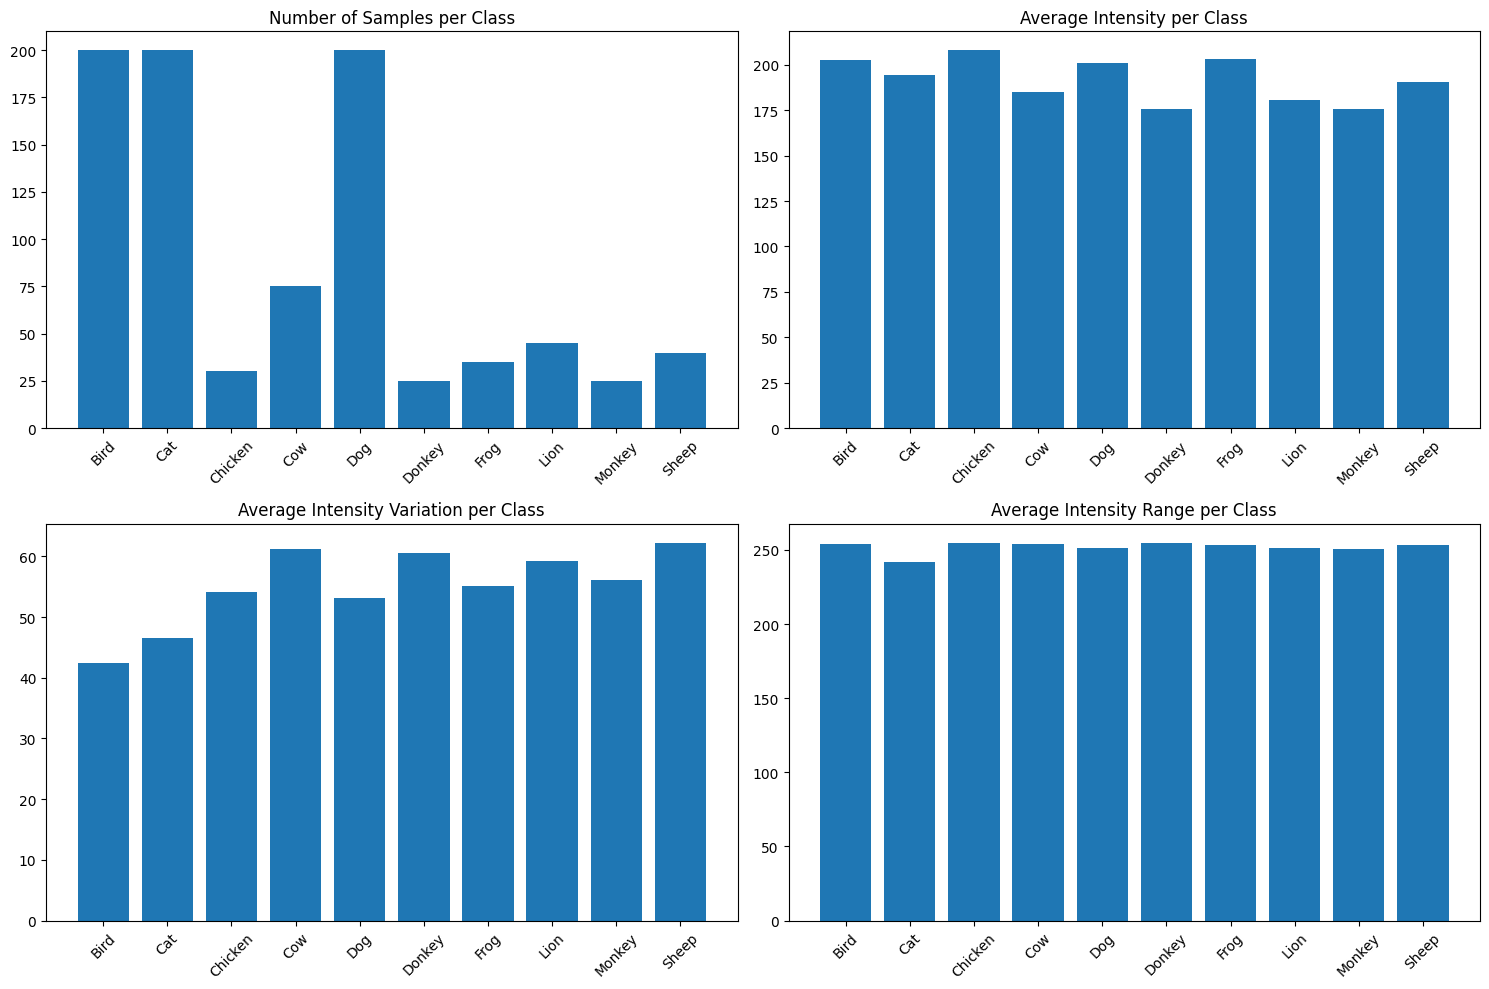

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from math import ceil

def visualize_dataset_spectrograms(dataset, class_names, samples_per_class=5):
    """
    Visualize spectrograms from each class in the dataset
    
    Args:
        dataset: Dataset where dataset[i][0] is spectrogram and dataset[i][1] is label
        class_names: List of class names
        samples_per_class: Number of samples to show per class
    """
    # Convert all class names to title case for consistency
    class_names = [name.title() for name in class_names]
    
    # Create dictionary to store examples for each class
    class_examples = {class_name: [] for class_name in class_names}
    
    # Collect examples for each class
    for i in range(len(dataset)):
        data = dataset[i][0]
        label = dataset[i][1]
        
        # Handle string labels by converting to title case
        if isinstance(label, str):
            class_name = label.title()
        else:
            # Handle numeric labels by using the class_names list
            class_name = class_names[label]
            
        if len(class_examples[class_name]) < samples_per_class:
            class_examples[class_name].append(data)
    
    # Calculate grid dimensions
    n_classes = len(class_names)
    n_cols = samples_per_class
    n_rows = n_classes
    
    # Create figure
    fig = plt.figure(figsize=(20, 3*n_rows))
    
    # Plot spectrograms for each class
    for i, class_name in enumerate(class_names):
        examples = class_examples[class_name]
        for j, spec in enumerate(examples):
            if j >= samples_per_class:
                break
                
            # Create subplot
            ax = plt.subplot(n_rows, n_cols, i*n_cols + j + 1)
            
            # Plot spectrogram
            img = ax.imshow(spec, aspect='auto', origin='lower', cmap='viridis')
            
            # Add title for first sample of each class
            if j == 0:
                ax.set_ylabel(f'{class_name}\nFrequency Bin')
            
            # Remove ticks for cleaner visualization
            ax.set_xticks([])
            ax.set_yticks([])
            
            # Add colorbar for last sample of each class
            if j == samples_per_class-1:
                plt.colorbar(img, ax=ax)
    
    plt.tight_layout()
    return fig

def visualize_dataset_statistics(dataset, class_names):
    """
    Visualize statistics about the spectrograms in the dataset
    """
    # Convert all class names to title case for consistency
    class_names = [name.title() for name in class_names]
    
    # Collect statistics for each class
    class_stats = {class_name: {
        'count': 0,
        'mean_intensity': [],
        'std_intensity': [],
        'max_intensity': [],
        'min_intensity': []
    } for class_name in class_names}
    
    # Calculate statistics
    for i in range(len(dataset)):
        data = dataset[i][0]
        label = dataset[i][1]
        
        # Handle string labels by converting to title case
        if isinstance(label, str):
            class_name = label.title()
        else:
            # Handle numeric labels by using the class_names list
            class_name = class_names[label]
            
        stats = class_stats[class_name]
        stats['count'] += 1
        stats['mean_intensity'].append(np.mean(data))
        stats['std_intensity'].append(np.std(data))
        stats['max_intensity'].append(np.max(data))
        stats['min_intensity'].append(np.min(data))
    
    # Create visualization of statistics
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot count distribution
    counts = [class_stats[c]['count'] for c in class_names]
    axes[0,0].bar(class_names, counts)
    axes[0,0].set_title('Number of Samples per Class')
    axes[0,0].set_xticklabels(class_names, rotation=45)
    
    # Plot mean intensity
    means = [np.mean(class_stats[c]['mean_intensity']) for c in class_names]
    axes[0,1].bar(class_names, means)
    axes[0,1].set_title('Average Intensity per Class')
    axes[0,1].set_xticklabels(class_names, rotation=45)
    
    # Plot intensity variation
    stds = [np.mean(class_stats[c]['std_intensity']) for c in class_names]
    axes[1,0].bar(class_names, stds)
    axes[1,0].set_title('Average Intensity Variation per Class')
    axes[1,0].set_xticklabels(class_names, rotation=45)
    
    # Plot intensity range
    ranges = [np.mean(class_stats[c]['max_intensity']) - np.mean(class_stats[c]['min_intensity']) 
             for c in class_names]
    axes[1,1].bar(class_names, ranges)
    axes[1,1].set_title('Average Intensity Range per Class')
    axes[1,1].set_xticklabels(class_names, rotation=45)
    
    plt.tight_layout()
    return fig

def analyze_full_dataset(dataset, class_names, samples_per_class=5):
    """
    Perform comprehensive analysis of the dataset
    """
    print("Generating spectrogram visualizations...")
    spec_fig = visualize_dataset_spectrograms(dataset, class_names, samples_per_class)
    
    print("\nGenerating dataset statistics...")
    stats_fig = visualize_dataset_statistics(dataset, class_names)
    
    return spec_fig, stats_fig


spec_fig, stats_fig = analyze_full_dataset(dataset, class_names, samples_per_class=5)
plt.show()

Generating spectrogram visualizations...


ValueError: too many values to unpack (expected 2)

In [ ]:
# https://pyimagesearch.com/2020/03/09/grad-cam-visualize-class-activation-maps-with-keras-tensorflow-and-deep-learning/
# https://medium.com/@bmuskan007/grad-cam-a-beginners-guide-adf68e80f4bb
# https://towardsdatascience.com/understand-your-algorithm-with-grad-cam-d3b62fce353


def generate_gradcam(model, input_tensor, target_class, layer_name):
    
    model.eval()
    
    # Get original dimensions
    _, _, height, width = input_tensor.shape
    
    # Storage for forward and backward values
    activations = []
    gradients = []
    
    # Forward hook
    def forward_hook(module, input, output):
        activations.append(output)
    
    # Backward hook
    def backward_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0])
    
    # Register hooks
    target_layer = None
    for name, module in model.named_modules():
        if name == layer_name:
            target_layer = module
            module.register_forward_hook(forward_hook)
            module.register_backward_hook(backward_hook)
    
    if target_layer is None:
        raise ValueError(f"Could not find layer {layer_name}")
    
    # Forward pass
    output = model(input_tensor)
    
    if target_class is None:
        target_class = output.argmax(dim=1)
    
    # Clear existing gradients
    model.zero_grad()
    
    # Target for backprop
    one_hot_output = torch.zeros_like(output)
    one_hot_output[0][target_class] = 1
    
    # Backward pass
    output.backward(gradient=one_hot_output)
    
    # Get gradient and activation
    gradient = gradients[0]
    activation = activations[0]
    
    # Calculate importance weights
    weights = torch.mean(gradient, dim=(2, 3))
    
    # Generate weighted activation map
    cam = torch.zeros(activation.shape[2:], device=activation.device)
    
    for i, w in enumerate(weights[0]):
        cam += w * activation[0, i, :, :]
    
    # Apply ReLU and normalize
    cam = F.relu(cam)
    
    # Resize CAM to match input dimensions
    cam = cam.unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions
    cam = F.interpolate(cam, size=(height, width), mode='bilinear', align_corners=False)
    cam = cam.squeeze()
    
    # Convert to numpy and normalize
    cam = cam.detach().cpu().numpy()
    cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
    
    return cam

def plot_spectrogram_analysis(spectrogram, model, target_class, class_names, layer_name):
    """
    Create comprehensive visualization of spectrogram analysis
    """
    # Generate Grad-CAM
    try:
        heatmap = generate_gradcam(model, spectrogram, target_class, layer_name)
    except Exception as e:
        print(f"Error generating Grad-CAM: {str(e)}")
        heatmap = np.zeros(spectrogram.shape[2:])
    
    # Get activation patterns
    activation_patterns = visualize_layer_patterns(model, spectrogram, layer_name)
    
    # Plot results
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Original spectrogram
    spec_data = spectrogram.squeeze().cpu().numpy()
    axes[0,0].imshow(spec_data, aspect='auto', cmap='viridis')
    axes[0,0].set_title('Original Spectrogram')
    axes[0,0].set_ylabel('Frequency Bin')
    axes[0,0].set_xlabel('Time')
    
    # Ensure heatmap matches spectrogram dimensions
    if heatmap.shape != spec_data.shape:
        print(f"Warning: Heatmap shape {heatmap.shape} doesn't match spectrogram shape {spec_data.shape}")
        heatmap = np.zeros_like(spec_data)
    
    # Grad-CAM heatmap
    axes[0,1].imshow(heatmap, aspect='auto', cmap='jet')
    axes[0,1].set_title(f'Grad-CAM Heatmap for {class_names[target_class]}')
    axes[0,1].set_ylabel('Frequency Bin')
    axes[0,1].set_xlabel('Time')
    
    # Overlay
    overlay = (0.6 * heatmap + 0.4 * spec_data)
    axes[1,0].imshow(overlay, aspect='auto')
    axes[1,0].set_title('Overlay of Spectrogram and Heatmap')
    axes[1,0].set_ylabel('Frequency Bin')
    axes[1,0].set_xlabel('Time')
    
    # Top activation patterns
    if len(activation_patterns.shape) > 2:
        n_filters = min(16, activation_patterns.shape[0])
        avg_activations = np.mean(activation_patterns[:n_filters], axis=(1,2))
        top_filter_idx = np.argsort(avg_activations)[-1]
        top_pattern = activation_patterns[top_filter_idx]
        axes[1,1].imshow(top_pattern, aspect='auto', cmap='viridis')
        axes[1,1].set_title(f'Top Filter Activation Pattern')
        axes[1,1].set_ylabel('Frequency Bin')
        axes[1,1].set_xlabel('Time')
    
    plt.tight_layout()
    return fig

In [46]:
dataset[0][0], dataset[0][1]

(array([[166, 176, 176, ..., 241, 241, 241],
        [165, 175, 175, ..., 255, 255, 255],
        [165, 175, 175, ..., 255, 255, 255],
        ...,
        [238, 252, 252, ..., 255, 255, 255],
        [237, 251, 251, ..., 255, 255, 255],
        [237, 251, 251, ..., 255, 255, 255]], dtype=uint8),
 'Bird')

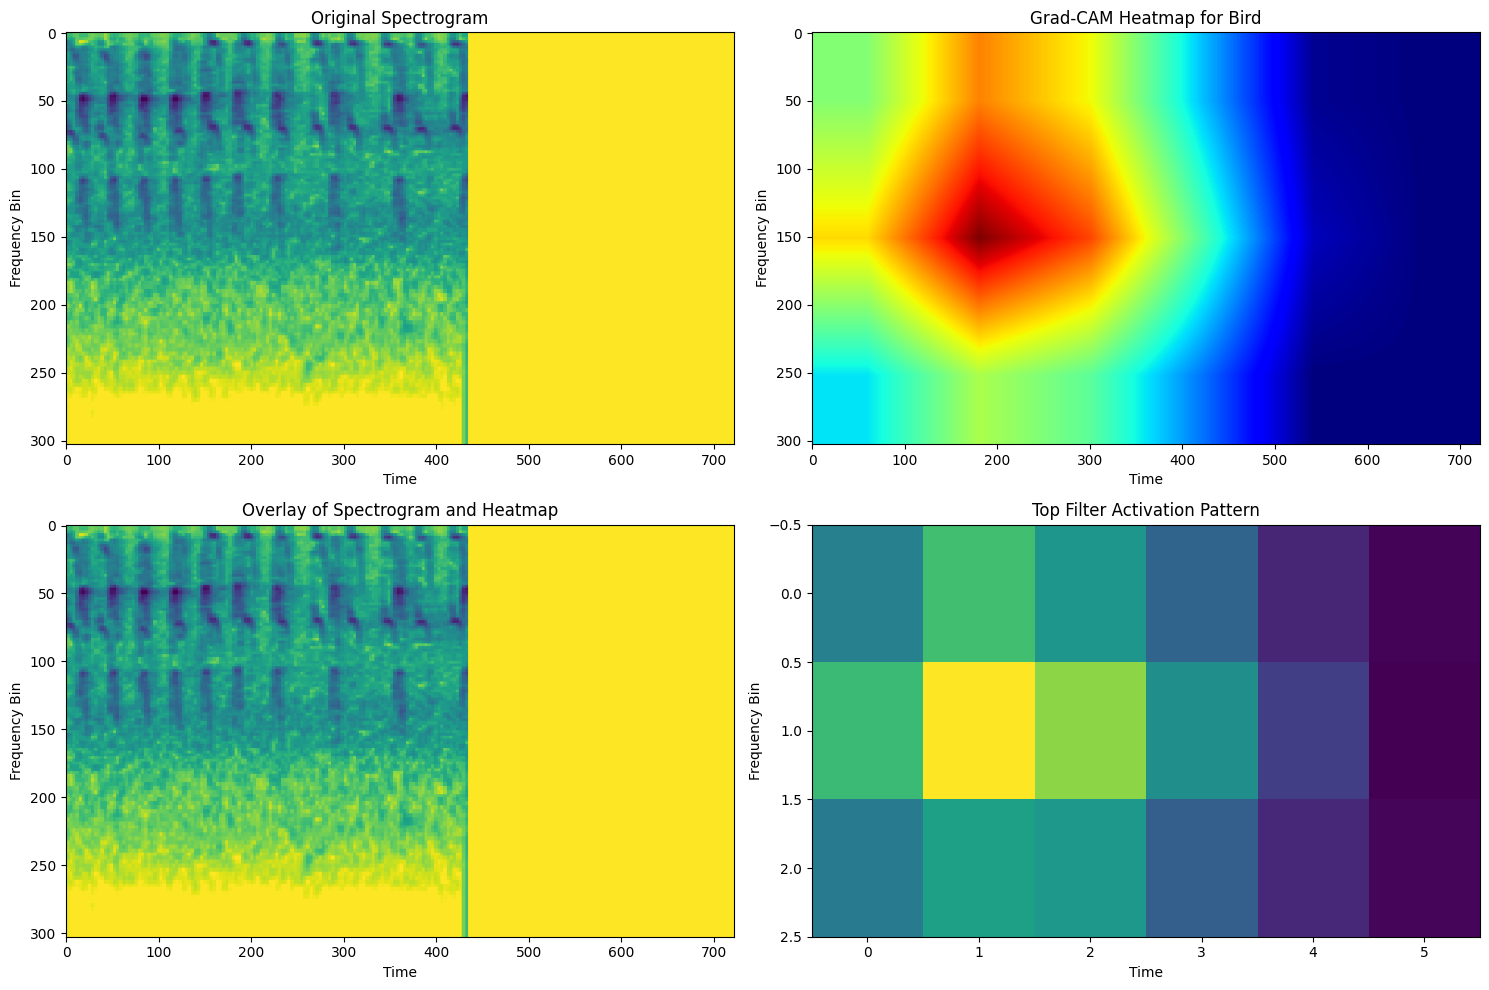

In [96]:
# For a single example:
spectrogram = dataset[0][0]
label = dataset[0][1]

# Convert label to numeric if needed
if isinstance(label, str):
    target_class = class_names.index(label.title())
else:
    target_class = label

# Prepare tensor
spectrogram_tensor = torch.FloatTensor(spectrogram).unsqueeze(0).unsqueeze(0).to(device)
spectrogram_tensor = torch.reshape(spectrogram_tensor, (spectrogram_tensor.shape[0], 1, 303, 722))

# Analyze with specific layer
layer_name = 'layer4.1.conv2'  # Use the last conv layer
fig = analyze_spectrogram(tf_model, spectrogram_tensor, target_class, class_names, layer_name)
plt.show()



In [91]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


predictions = []
accuracy, predictions = evaluate_model(tf_model, val, 10, device)
print("Accuracy: ", accuracy)

pred_labels = []
for batch in predictions:
    for prediction in batch:
        x = (prediction == torch.max(prediction)).nonzero(as_tuple=False)[0]
        pred_labels.append(x)
pred_labels = list(map(lambda x: x.cpu().numpy().item(), pred_labels))
print(pred_labels)
print(classes)

Accuracy:  tensor(0.9029, device='cuda:0')
[8, 8, 4, 4, 4, 4, 4, 1, 4, 1, 1, 9, 0, 7, 3, 7, 4, 7, 1, 4, 1, 0, 0, 7, 4, 1, 4, 4, 0, 0, 8, 1, 1, 4, 1, 1, 3, 0, 1, 4, 1, 0, 0, 0, 1, 4, 0, 9, 0, 0, 1, 0, 4, 4, 1, 3, 1, 0, 1, 4, 3, 4, 0, 0, 2, 6, 0, 0, 9, 0, 1, 1, 0, 1, 4, 3, 8, 5, 4, 0, 0, 1, 0, 0, 4, 4, 4, 4, 1, 0, 4, 0, 1, 3, 7, 3, 4, 7, 3, 0, 0, 7, 4, 1, 0, 4, 1, 7, 4, 4, 1, 1, 0, 4, 1, 3, 0, 1, 1, 9, 1, 1, 1, 7, 1, 2, 1, 3, 0, 8, 2, 6, 4, 4, 7, 4, 2, 8, 1, 1, 3, 3, 1, 0, 0, 1, 4, 1, 0, 1, 6, 0, 4, 1, 4, 4, 3, 9, 1, 0, 2, 1, 1, 9, 1, 4, 4, 4, 1, 1, 3, 4, 4, 1, 4]
['bird', 'cat', 'chicken', 'cow', 'dog', 'donkey', 'frog', 'lion', 'monkey', 'sheep']


In [141]:
from torchsummary import summary

summary(tf_model, (1, 303, 722))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 3, 76, 180]             246
       BatchNorm2d-2           [-1, 3, 76, 180]               6
              ReLU-3           [-1, 3, 76, 180]               0
            Conv2d-4           [-1, 64, 38, 90]           9,408
       BatchNorm2d-5           [-1, 64, 38, 90]             128
              ReLU-6           [-1, 64, 38, 90]               0
         MaxPool2d-7           [-1, 64, 19, 45]               0
            Conv2d-8           [-1, 64, 19, 45]          36,864
       BatchNorm2d-9           [-1, 64, 19, 45]             128
             ReLU-10           [-1, 64, 19, 45]               0
           Conv2d-11           [-1, 64, 19, 45]          36,864
      BatchNorm2d-12           [-1, 64, 19, 45]             128
             ReLU-13           [-1, 64, 19, 45]               0
       BasicBlock-14           [-1, 64,

In [31]:
import pickle

# Loads Model
with open('ResNet.pickle','rb') as modelFile: 
     tf_model = pickle.load(modelFile)

In [92]:
predictions = []
accuracy, predictions = evaluate_model(tf_model, val, 10, device)
print("Accuracy: ", accuracy)

pred_labels = []
for batch in predictions:
    for prediction in batch:
        x = (prediction == torch.max(prediction)).nonzero(as_tuple=False)[0]
        pred_labels.append(x)
pred_labels = list(map(lambda x: x.cpu().numpy().item(), pred_labels))
print(pred_labels)
print(classes)

Accuracy:  tensor(0.9029, device='cuda:0')
[3, 0, 8, 4, 1, 3, 0, 0, 4, 4, 4, 1, 8, 1, 9, 0, 1, 0, 7, 4, 4, 4, 0, 1, 4, 1, 0, 4, 8, 4, 3, 0, 4, 0, 1, 7, 1, 0, 0, 1, 1, 6, 4, 3, 0, 5, 4, 0, 0, 0, 4, 7, 1, 4, 0, 1, 1, 1, 0, 3, 7, 1, 4, 1, 3, 4, 1, 1, 9, 6, 9, 1, 4, 1, 0, 4, 4, 0, 0, 4, 4, 8, 7, 1, 4, 1, 9, 8, 1, 0, 0, 3, 3, 3, 1, 0, 1, 7, 7, 1, 0, 1, 2, 0, 0, 2, 8, 4, 1, 4, 6, 0, 0, 0, 7, 4, 1, 1, 1, 3, 0, 0, 7, 0, 2, 9, 4, 3, 4, 1, 4, 4, 4, 1, 0, 0, 7, 3, 4, 1, 1, 4, 1, 1, 0, 1, 4, 1, 0, 1, 4, 3, 1, 4, 1, 2, 9, 4, 1, 4, 1, 1, 1, 3, 1, 4, 4, 4, 1, 4, 4, 1, 4, 2, 0]
['bird', 'cat', 'chicken', 'cow', 'dog', 'donkey', 'frog', 'lion', 'monkey', 'sheep']


In [30]:
print(dataset)

[(array([[166, 176, 176, ..., 241, 241, 241],
       [165, 175, 175, ..., 255, 255, 255],
       [165, 175, 175, ..., 255, 255, 255],
       ...,
       [238, 252, 252, ..., 255, 255, 255],
       [237, 251, 251, ..., 255, 255, 255],
       [237, 251, 251, ..., 255, 255, 255]], dtype=uint8), 'Bird', 44100), (array([[186, 197, 197, ..., 241, 241, 241],
       [189, 201, 201, ..., 255, 255, 255],
       [189, 201, 201, ..., 255, 255, 255],
       ...,
       [223, 236, 236, ..., 255, 255, 255],
       [223, 236, 236, ..., 255, 255, 255],
       [223, 236, 236, ..., 255, 255, 255]], dtype=uint8), 'Bird', 44100), (array([[154, 164, 164, ..., 149, 149, 149],
       [154, 164, 164, ..., 158, 162, 162],
       [154, 164, 164, ..., 158, 162, 162],
       ...,
       [ 73,  78,  78, ..., 120,  85,  85],
       [ 50,  53,  53, ...,  68,  77,  77],
       [ 50,  53,  53, ...,  68,  77,  77]], dtype=uint8), 'Bird', 44100), (array([[187, 198, 198, ..., 241, 241, 241],
       [198, 210, 210, ..., 25